# Jupyter notebook illustrating aspects of disparity estimation seminar

First of all, we load the following libraries
* cv2, the OpenCV library containing implementations of many image processing and computer vision algorithms,
* math and numpy for some general math,
* and finally matplotlib for displaying our results.

In [1]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt

## Disparity estimation

We first load a left and right image as input for our disparity estimation. We convert the images into grayscale to simplify some of the computations.

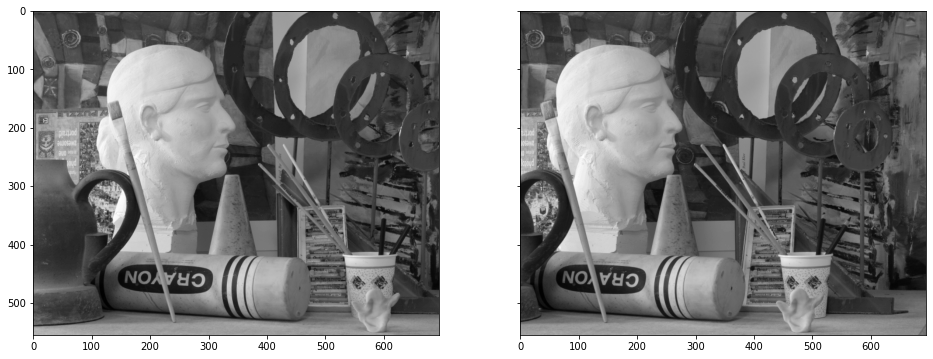

In [2]:
img_l = cv2.imread('data/view_left.png')
img_r = cv2.imread('data/view_right.png')
h,w,c = img_l.shape
img_l= cv2.resize(img_l,(round(0.5*w), round(0.5*h)), interpolation = cv2.INTER_LINEAR)
img_r= cv2.resize(img_r,(round(0.5*w), round(0.5*h)), interpolation = cv2.INTER_LINEAR)
I_gray_l = cv2.cvtColor(img_l, cv2.COLOR_BGR2GRAY)
I_gray_r = cv2.cvtColor(img_r, cv2.COLOR_BGR2GRAY)

fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(16, 12), sharex=True, sharey=True)
ax1.imshow(I_gray_l,'gray')
ax2.imshow(I_gray_r,'gray')
plt.show()

A border is added to the right of the image to avoid problems in the further calculations with indices that would run outside of the image borders. 

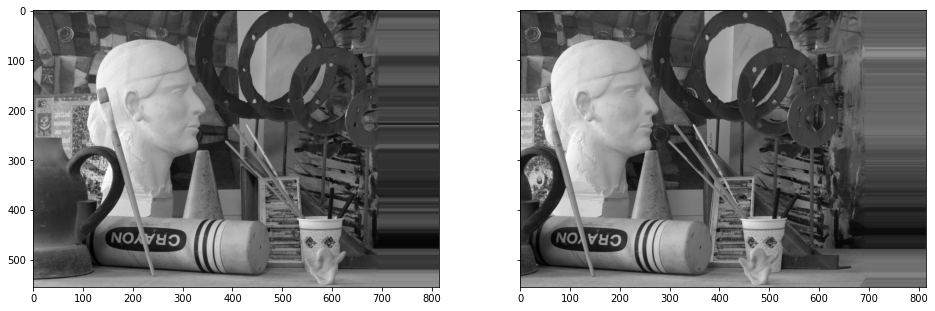

In [3]:
dmin = 0
dmax = 120
img_l_pad = np.float32(cv2.copyMakeBorder(I_gray_l,0, 0, -dmin, dmax, cv2.BORDER_REPLICATE,0))
img_r_pad = np.float32(cv2.copyMakeBorder(I_gray_r,0, 0, -dmin, dmax, cv2.BORDER_REPLICATE,0))
h,w = I_gray_l.shape

fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(16, 12), sharex=True, sharey=True)
ax1.imshow(img_l_pad,'gray')
ax2.imshow(img_r_pad,'gray')

### Cost volume calculation
We calculate the cost volume using the absolute grayscale image difference between left and right image as cost measure. 

In [4]:
cost_volume = np.zeros([h,w,dmax-dmin])
for i in range(dmin,dmax):
    cost_volume[:,:,i-dmin] = abs(img_l_pad[:,i-dmin:i-dmin+w] - img_r_pad[:,-dmin:-dmin+w])

We can display slices of the cost volume at different disparity levels, showing the error image for various disparity levels. 

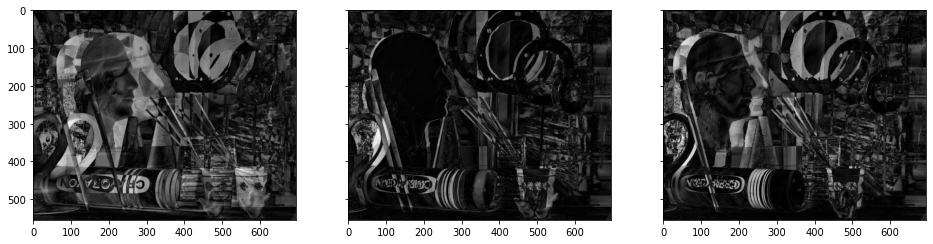

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(16, 6), sharex=True, sharey=True)
ax1.imshow(cost_volume[:,:,0], 'gray')
ax2.imshow(cost_volume[:,:,72], 'gray')
ax3.imshow(cost_volume[:,:,100], 'gray')
plt.show()

Let us now plot row 300 from the left (blue) and right (orange) image, and try to find the best match at pixel (300,186). 

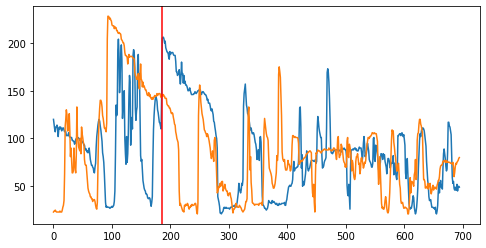

In [6]:
r = 300
c = 186
d = 0
fig, (ax1) = plt.subplots(ncols=1, figsize=(8, 4))
ax1.plot(img_l_pad[r,d-dmin:d-dmin+w])
ax1.plot(img_r_pad[r,-dmin:-dmin+w])
ax1.axvline(x=c, color='red')
plt.show()

In a first attempt, we examine the cost volume at location (300,186). The minimum value can be found at disparity 50, so we shift the left image by 50 pixels and plot this together with the original right image line.

Note how the error is 0 at this location for disparity 50, but the plots don't seem to match well yet. 

optimum in the cost volume is found at  (0, 50)  with a cost of  0.0


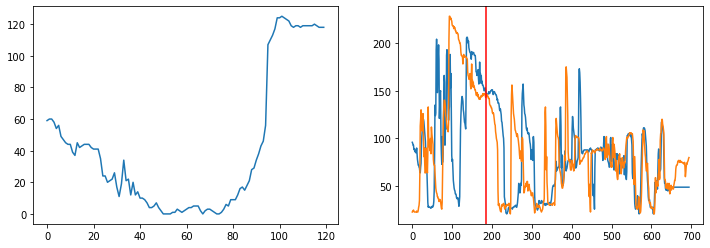

In [7]:
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(cost_volume[r,c,:])
print("optimum in the cost volume is found at ", min_loc, " with a cost of ", min_val)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))
ax1.plot(range(dmin,dmax),cost_volume[r,c,:])
d=min_loc[1]
ax2.plot(img_l_pad[r,d-dmin:d-dmin+w])
ax2.plot(img_r_pad[r,-dmin:-dmin+w])
ax2.axvline(x=c, color='red')
plt.show()

If we apply this to the entire cost volume, and select at each pixel location the disparity with the lowest cost, we get the following disparity image. 

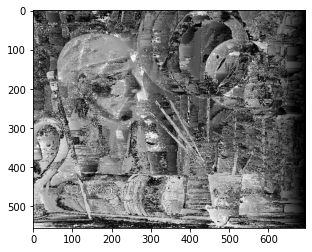

In [8]:
depth = np.argmin(cost_volume, axis=2)
plt.imshow(depth, 'gray')
plt.show()

Note how the result is very noisy. Therefore, let us evaluate the cost also at neighboring pixels when building the cost volume. In this way, we aggregate the matching cost of neighboring pixels into the cost volume. 

optimum in the cost volume is found at  (0, 72)  with a cost of  52.0


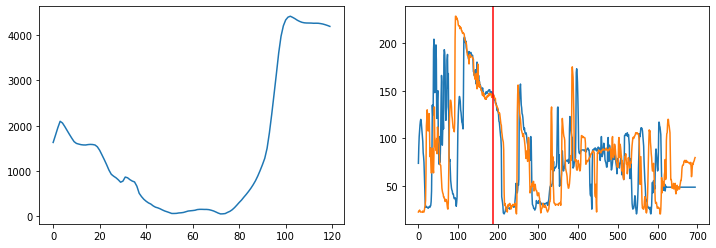

In [9]:
cost_volume2 = np.zeros([h,w,dmax-dmin])
win = 3
for i in range(dmin,dmax):
    for j in range(-win,win):
        for k in range(-win,win):
            cost_volume2[win:-win,win:-win,i-dmin] += abs(img_l_pad[win+j:-win+j,i-dmin+win+k:i-dmin+w-win+k] - img_r_pad[win+j:-win+j,-dmin+win+k:-dmin+w-win+k])

min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(cost_volume2[r,c,:])
print("optimum in the cost volume is found at ", min_loc, " with a cost of ", min_val)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))
ax1.plot(range(dmin,dmax),cost_volume2[r,c,:])
d=min_loc[1]
ax2.plot(img_l_pad[r,d-dmin:d-dmin+w])
ax2.plot(img_r_pad[r,-dmin:-dmin+w])
ax2.axvline(x=c, color='red')
plt.show()

Equivalently, this can be done by filtering the original cost volume. The result is already much better.

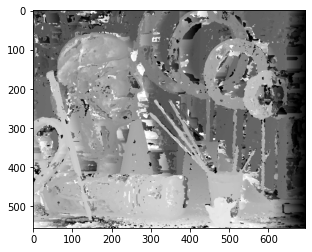

In [10]:
kernel_size = 5
kernel = np.ones((kernel_size,kernel_size),np.float32)/(kernel_size*kernel_size)
costvolume_filt = cv2.filter2D(cost_volume,-1,kernel)

depth = np.argmin(costvolume_filt, axis=2)

plt.imshow(depth, 'gray')
plt.show()

### Disparity estimation in OpenCV
OpenCV already includes implementations of a few disparity estimation algorithms, which are shown below.

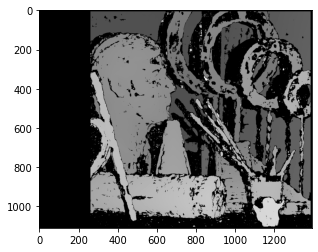

In [11]:
imgL = cv2.imread('data/view_left.png',0)
imgR = cv2.imread('data/view_right.png',0)

stereo = cv2.StereoBM_create(numDisparities=256, blockSize=15)
disparity = stereo.compute(imgL,imgR)
plt.imshow(disparity,'gray')
plt.show()

Finally, the code below shows another disparity estimation algorithm. 
It also projects the image pixels back into 3D space using the estimated disparities. This result is stored in the file out.ply, and can be visualized using a tool like the open source Meshlab. 

loading images...
computing disparity...
generating 3d point cloud...
out.ply saved


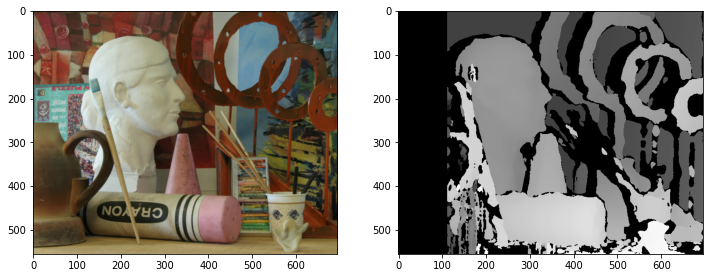

In [12]:
'''
Simple example of stereo image matching and point cloud generation.
Resulting .ply file cam be easily viewed using MeshLab ( http://meshlab.sourceforge.net/ )
'''

ply_header = '''ply
format ascii 1.0
element vertex %(vert_num)d
property float x
property float y
property float z
property uchar red
property uchar green
property uchar blue
end_header
'''

def write_ply(fn, verts, colors):
    verts = verts.reshape(-1, 3)
    colors = colors.reshape(-1, 3)
    verts = np.hstack([verts, colors])
    with open(fn, 'wb') as f:
        f.write((ply_header % dict(vert_num=len(verts))).encode('utf-8'))
        np.savetxt(f, verts, fmt='%f %f %f %d %d %d ')


if __name__ == '__main__':
    print('loading images...')
    imgL = cv2.pyrDown( cv2.imread('./data/view_left.png') )  # downscale images for faster processing
    imgR = cv2.pyrDown( cv2.imread('./data/view_right.png') )

    # disparity range is tuned for 'aloe' image pair
    window_size = 3
    min_disp = 16
    num_disp = 112-min_disp
    stereo = cv2.StereoSGBM_create(minDisparity = min_disp,
        numDisparities = num_disp,
        blockSize = 16,
        P1 = 8*3*window_size**2,
        P2 = 32*3*window_size**2,
        disp12MaxDiff = 1,
        uniquenessRatio = 10,
        speckleWindowSize = 100,
        speckleRange = 32
    )

    print('computing disparity...')
    disp = stereo.compute(imgL, imgR).astype(np.float32) / 16.0

    print('generating 3d point cloud...',)
    h, w = imgL.shape[:2]
    f = 0.8*w                          # guess for focal length
    Q = np.float32([[1, 0, 0, -0.5*w],
                    [0,-1, 0,  0.5*h], # turn points 180 deg around x-axis,
                    [0, 0, 0,     -f], # so that y-axis looks up
                    [0, 0, 1,      0]])
    points = cv2.reprojectImageTo3D(disp, Q)
    colors = cv2.cvtColor(imgL, cv2.COLOR_BGR2RGB)
    mask = disp > disp.min()
    out_points = points[mask]
    out_colors = colors[mask]
    out_fn = 'out.ply'
    write_ply('out.ply', out_points, out_colors)
    print('%s saved' % 'out.ply')

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 8))
    ax1.imshow(cv2.cvtColor(imgL, cv2.COLOR_BGR2RGB))
    ax2.imshow((disp-min_disp)/num_disp,'gray')

In [13]:
import open3d as o3d

pcd = o3d.io.read_point_cloud('out.ply')

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [14]:
from lib.plots import plot_point_cloud

plot = plot_point_cloud(pcd)

plot.camera = [
    5.4, 2.0, 4.0,
    0, 0, -18,
    0, 1, 0
]

plot.display()

Output()